In [1]:
import pandas as pd
import glob
import os
import numpy as np
from pyannote.metrics.base import BaseMetric
from inaGVAD.gender_metrics import WstpErr, IdentificationErrorRateLabel
from pyannote.metrics.identification import IdentificationErrorRate

In [2]:
from pyannote.core import Annotation, Timeline, Segment

def df2annot(df, col, rmnan=True, uri=None):
    an = Annotation(uri=uri)
#    print('df2annot', df)
    for start, stop, val in zip(df.start, df.stop, df[col]):
        if rmnan and val != val:
            continue
        seg = Segment(start, stop)
        an[seg] = val
    return an.support()


def init_uem(df):
    uem = Timeline()
    uem.add(Segment(df.start[0], df.stop[len(df) - 1]))
    return uem


def rm_uem(uem, df, col, rmlist):
    for start, stop, val in zip(df.start, df.stop, df[col]):
        if val in rmlist:
            uem = uem.extrude(Segment(start, stop))
    return uem

def keep_uem(uem, df, col, keeplist):
    for start, stop, val in zip(df.start, df.stop, df[col]):
        if val not in keeplist:
            uem = uem.extrude(Segment(start, stop))
    return uem


class GenderEval:
    def __init__(self, collar=.3):
        self.wstp = WstpErr()
        self.ier = IdentificationErrorRate(collar=collar)        
        self.ierF = IdentificationErrorRateLabel('female', collar=collar)
        self.ierM = IdentificationErrorRateLabel('male', collar=collar)
        
    def __call__(self, fref, fpred):
        
        uri, _ = os.path.splitext(os.path.basename(fref))
        
        # parse reference
        dfref = pd.read_csv(fref)
        anref = df2annot(dfref, 'speaker_gender', uri = uri)
        uem = init_uem(dfref)
        uem = rm_uem(uem, dfref, 'speaker_gender', ['undefgender'])
        #print('main uem', uem)
        #print(uem)
        
        # parse prediction
        dfpred = pd.read_csv(fpred)
        #print('dfpred', dfpred)
        if len(dfpred) > 0:
            dfpred = dfpred[dfpred.label.map(lambda x: x in ['male', 'female'])]
        anpred = df2annot(dfpred, 'label', uri = uri)
            
        wstp = self.wstp(anref, anpred, uem=None)
        
        ier = self.ier(anref, anpred, uem=uem)
        errF = self.ierF(anref,anpred,uem=uem)
        errM = self.ierM(anref,anpred,uem=uem)
        
        return wstp, ier, errF, errM
    
    def reset(self):
        self.wstp.reset()
        self.ier.reset()
        self.ierF.reset()
        self.ierM.reset()
        
    def report(self):
        wstp = self.wstp.report()
        wstp.columns = [('WSTP', e1, e2) for e1, e2 in wstp.columns]
        ier = self.ier.report()
        ier.columns = [('IER', e1, e2) for e1, e2 in ier.columns]
        ierF = self.ierF.report()
        ierF.columns = [('IER Female', e1, e2) for e1, e2 in ierF.columns]
        ierM = self.ierM.report()
        ierM.columns = [('IER Male', e1, e2) for e1, e2 in ierM.columns]
        return wstp.join(ier).join(ierF).join(ierM)
        
#        if onlypercent:
#            ret = ret[[k for k in ret if k[2] == '%']]
#            ret.columns = [(e1, e2) for (e1, e2, e3) in ret]
#        return ret

    def compare_lfiles(self, lref, lhyp, simplify=None):
#        assert(simplify in [None, 'onlypercent', 'genderdetail', 'gender', ''])

        for ref, hyp in zip(lref, lhyp):
            self(ref, hyp)
        ret = self.report()
        self.reset()
        return ret
        
#        if simplify == 'only percent':
#            ret = ret[[k for k in ret if k[2] == '%']]
#            ret.columns = [(e1, e2) for (e1, e2, e3) in ret]

    
    def compare_category(self, pred_dir, criterion, csvfname='./annotations/filesplit/testset.csv'):

        df = pd.read_csv(csvfname)
        lret = []
        #ldf = []
        #dret = {}
        ltotal = []
        
        for k, sdf in df.groupby(criterion):
            src = sdf.fileid.map(lambda x: './annotations/detailed_csv/%s.csv' % x)
            dst = sdf.fileid.map(lambda x: '%s/%s.csv' % (pred_dir, x))
            
            ret = self.compare_lfiles(src, dst)

            # remove total from result
            dtotal = ret.tail(1).to_dict(orient='records')[0]    
            ret = ret[:(len(ret) - 1)]
            lret.append(ret)
  
            if isinstance(criterion, list):
                for i, key in enumerate(criterion):
                    dtotal[key] = k[i]
            else:
                dtotal[criterion] = k

            dtotal['nbfile'] = len(ret)
            wstp = ret[('WSTP', 'WSTP error', '%')]
            dtotal['WSTP_RMSE'] = np.sqrt(np.mean(wstp ** 2))
            
            ltotal.append(dtotal)

        details = df.join(pd.concat(lret), on='fileid')
        return details, pd.DataFrame.from_dict(ltotal).set_index(criterion)
    
    def global_eval(self, pred_dir, csvfname='./annotations/filesplit/testset.csv'):

        df = pd.read_csv(csvfname)
        src = df.fileid.map(lambda x: './annotations/detailed_csv/%s.csv' % x)
        dst = df.fileid.map(lambda x: '%s/%s.csv' % (pred_dir, x))

        ret = self.compare_lfiles(src, dst)

        dtotal = ret.tail(1).to_dict(orient='records')[0]
        ret = ret[:(len(ret) - 1)]

        dtotal['nbfile'] = len(ret)
        wstp = ret[('WSTP', 'WSTP error', '%')]
        dtotal['WSTP_RMSE'] = np.sqrt(np.mean(wstp ** 2))

        details = df.join(ret, on='fileid')
        return details, dtotal

def tuple3cols(df):
    return [k for k in df.columns if isinstance(k, tuple) and len(k) == 3]

def simplify_results(df, rmdur=True, iergbias = True, ierdetail=False, iergender = False, genderdetail=False, rmNbFile=True):
    #assert strategy in ['percents', 'wstp_ier', 'wstp_iergender', 'wstp_iergenderdetail']
    
#    if add_speech_percent:
#        
#        if 'nbfile' in df:
#            nbfile = df.nbfile
#            df = df.drop(['nbfile'], axis=1)
        
    ldrop = []
    if rmdur:
        ldrop += [k for k in df.columns if isinstance(k, tuple) and len(k) == 3 and k[2] != '%']
        
    if iergbias:
        df['IER gender bias'] = df[('IER Female', 'identification error rate', '%')] - df[('IER Male', 'identification error rate', '%')]
    
    if rmNbFile:
        ldrop.append('nbfile')
    
    if not iergender:
        ldrop += [('IER Female', 'identification error rate', '%'), ('IER Male', 'identification error rate', '%')]
    
    if ierdetail == False:
        ldrop += [k for k in tuple3cols(df) if k[0] == 'IER' and k[1] != 'identification error rate']

    if genderdetail == False:
        ldrop += [k for k in tuple3cols(df) if k[0] in ['IER Female', 'IER Male'] and k[1] != 'identification error rate']
        
    return df.drop(ldrop, axis=1)    

In [3]:
# init evaluator and COLLAR (zone to ignore around boundaries)
ge = GenderEval(collar=0.3)

In [4]:
ref = './annotations/detailed_csv/'
lref = sorted(glob.glob('./annotations/detailed_csv/*.csv'))
iss = './automatic_baselines/inaspeechsegmenter/'
liss = sorted(glob.glob('./automatic_baselines/inaspeechsegmenter/*.csv'))
lium = './automatic_baselines/liumspkdiarization_csv/'
llium = sorted(glob.glob('./automatic_baselines/liumspkdiarization_csv/*.csv'))

gender_baselines = ['inaspeechsegmenter', 'iss23', 'liumspkdiarization_csv', 'referencevad_ecapa', 'inaspeechsegmentervad_ecapa',  'pyannotevad_ecapa',  'rvad_ecapa',  'silero_ecapa',  'speechbrainvad_ecapa']

In [5]:
lresults = []
# evaluation performed on dev split : return results per file in details and per category in category
for baseline in gender_baselines:
    details, categories = ge.compare_category('./automatic_baselines/' + baseline, ['channel_category'])#, 'vad_difficulty'])
    lresults.append(simplify_results(categories))

In [6]:
lresults[0]

,"(WSTP, WSTP error, %)","(IER, identification error rate, %)",WSTP_RMSE,IER gender bias
channel_category,,,,
generalist_radio,0.670746,5.851559,4.434916,0.287743
generalist_tv,-1.437044,25.517894,16.602669,0.986839
music_radio,3.610936,16.286951,15.770984,-18.142881
news_tv,1.042652,6.466632,4.254993,-1.825180


In [7]:
lchancat = ['generalist_radio', 'music_radio', 'generalist_tv', 'news_tv']
lmetricmap = [(('IER', 'identification error rate', '%'), 'IER'),
              #('IER gender bias', 'IER Gb'),
              (('WSTP', 'WSTP error', '%'), 'WSTP_ERR'),
              ('WSTP_RMSE','WSTP_RMSE')
]

cols = ['model']

for cat in lchancat:
    for imetric, metric in lmetricmap:
        cols.append((cat, metric))
print(cols)
        
lret = []
for model, result in zip(gender_baselines, lresults):
    d = {'model': model}
    for cat in lchancat:
        for imetric, metric in lmetricmap:
            d[(cat, metric)] = result[imetric][cat]
    lret.append(d)

df = pd.DataFrame.from_records(lret, columns=cols)
df
print(df.to_latex(float_format='%.1f', index=False).replace('_', '\_'))
#dret

['model', ('generalist_radio', 'IER'), ('generalist_radio', 'WSTP_ERR'), ('generalist_radio', 'WSTP_RMSE'), ('music_radio', 'IER'), ('music_radio', 'WSTP_ERR'), ('music_radio', 'WSTP_RMSE'), ('generalist_tv', 'IER'), ('generalist_tv', 'WSTP_ERR'), ('generalist_tv', 'WSTP_RMSE'), ('news_tv', 'IER'), ('news_tv', 'WSTP_ERR'), ('news_tv', 'WSTP_RMSE')]
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
model & ('generalist\_radio', 'IER') & ('generalist\_radio', 'WSTP\_ERR') & ('generalist\_radio', 'WSTP\_RMSE') & ('music\_radio', 'IER') & ('music\_radio', 'WSTP\_ERR') & ('music\_radio', 'WSTP\_RMSE') & ('generalist\_tv', 'IER') & ('generalist\_tv', 'WSTP\_ERR') & ('generalist\_tv', 'WSTP\_RMSE') & ('news\_tv', 'IER') & ('news\_tv', 'WSTP\_ERR') & ('news\_tv', 'WSTP\_RMSE') \\
\midrule
inaspeechsegmenter & 5.9 & 0.7 & 4.4 & 16.3 & 3.6 & 15.8 & 25.5 & -1.4 & 16.6 & 6.5 & 1.0 & 4.3 \\
iss23 & 6.8 & -0.2 & 4.8 & 19.0 & 5.5 & 16.2 & 25.9 & -5.9 & 19.2 & 6.6 & -0.6 & 3.5 \\
liumspkdiarization\_csv & 9.8 &

In [8]:
ldresult = []
for baseline in gender_baselines:
    details, dresult = ge.global_eval('./automatic_baselines/' + baseline)
    dresult['system'] = baseline
    ldresult.append(dresult)
dfresult = pd.DataFrame.from_dict(ldresult)
dfresult = simplify_results(dfresult, iergender=True, genderdetail=True)
dfresult
#simplify_results(dresult)

,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Female, correct, %)","(IER Female, false alarm, %)","(IER Female, missed detection, %)","(IER Female, confusion, %)","(IER Male, identification error rate, %)","(IER Male, correct, %)","(IER Male, false alarm, %)","(IER Male, missed detection, %)","(IER Male, confusion, %)",WSTP_RMSE,system,IER gender bias
0,-0.098774,14.584712,15.119524,94.141755,7.357324,2.956229,4.805971,14.290907,94.737354,10.074217,2.622438,1.594252,13.327144,inaspeechsegmenter,0.828617
1,-2.587023,15.146195,20.905458,94.792020,10.909442,2.956229,7.039787,11.982285,93.510184,8.122825,2.622438,1.237022,14.826290,iss23,8.923173
2,-6.000534,36.764284,56.573759,88.204238,32.432041,4.675598,19.466120,25.881749,85.700567,18.364692,3.605523,3.911534,29.133003,liumspkdiarization_csv,30.692009
3,2.015207,2.954429,2.467701,94.135326,0.000000,0.000000,2.467701,3.221818,98.644344,0.000000,0.000000,3.221818,8.815250,referencevad_ecapa,-0.754117
4,11.105639,73.243209,20.890881,93.358619,17.958319,0.000000,2.932562,102.003488,98.388967,98.354979,0.000000,3.648510,25.210837,inaspeechsegmentervad_ecapa,-81.112607
5,11.621526,73.604828,18.556346,92.943085,15.063297,0.000000,3.493049,103.846267,98.081058,99.969480,0.000000,3.876787,25.810709,pyannotevad_ecapa,-85.289921
6,12.977822,74.339331,16.076230,90.576452,12.806190,0.000000,3.270040,106.346753,98.203570,101.169832,0.000000,5.176921,26.396702,rvad_ecapa,-90.270523
7,5.192711,30.668081,15.115102,90.726642,9.943564,2.003945,3.167593,39.212268,95.790418,32.749310,2.469433,3.993525,21.780456,silero_ecapa,-24.097166
8,10.852366,73.519915,22.042450,92.940641,18.791860,0.000000,3.250591,101.799579,98.214255,97.921449,0.000000,3.878130,25.058364,speechbrainvad_ecapa,-79.757128


In [9]:
lmetricmap = [('system', 'system'),
              (('IER', 'identification error rate', '%'), 'IER'),
#              ('IER gender bias', 'IGB'),
              ('WSTP_RMSE', 'WSTPRMSE'),
              (('WSTP', 'WSTP error', '%'), 'WSTPERR'),
              (('IER Female', 'identification error rate', '%'), 'IERF'),
              (('IER Female', 'correct', '%'), 'recallF'),
              (('IER Female', 'false alarm', '%'), 'faF'),
              (('IER Female', 'missed detection', '%'), 'mdF'),
              (('IER Female', 'confusion', '%'), 'conF'),
              (('IER Male', 'identification error rate', '%'), 'IERM'),
              (('IER Male', 'correct', '%'), 'recallM'),
              (('IER Male', 'false alarm', '%'), 'faM'),
              (('IER Male', 'missed detection', '%'), 'mdM'),
              (('IER Male', 'confusion', '%'), 'conM'),
    
]

ldrec = []
for i, system in enumerate(dfresult.system):
    d = {}
    for oldname, newname in lmetricmap:
        pass
        d[newname] = dfresult[oldname][i]
    ldrec.append(d)

print(pd.DataFrame.from_dict(ldrec).to_latex(float_format='%.1f', index=False).replace('_',''))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
system & IER & WSTPRMSE & WSTPERR & IERF & recallF & faF & mdF & conF & IERM & recallM & faM & mdM & conM \\
\midrule
inaspeechsegmenter & 14.6 & 13.3 & -0.1 & 15.1 & 94.1 & 7.4 & 3.0 & 4.8 & 14.3 & 94.7 & 10.1 & 2.6 & 1.6 \\
iss23 & 15.1 & 14.8 & -2.6 & 20.9 & 94.8 & 10.9 & 3.0 & 7.0 & 12.0 & 93.5 & 8.1 & 2.6 & 1.2 \\
liumspkdiarizationcsv & 36.8 & 29.1 & -6.0 & 56.6 & 88.2 & 32.4 & 4.7 & 19.5 & 25.9 & 85.7 & 18.4 & 3.6 & 3.9 \\
referencevadecapa & 3.0 & 8.8 & 2.0 & 2.5 & 94.1 & 0.0 & 0.0 & 2.5 & 3.2 & 98.6 & 0.0 & 0.0 & 3.2 \\
inaspeechsegmentervadecapa & 73.2 & 25.2 & 11.1 & 20.9 & 93.4 & 18.0 & 0.0 & 2.9 & 102.0 & 98.4 & 98.4 & 0.0 & 3.6 \\
pyannotevadecapa & 73.6 & 25.8 & 11.6 & 18.6 & 92.9 & 15.1 & 0.0 & 3.5 & 103.8 & 98.1 & 100.0 & 0.0 & 3.9 \\
rvadecapa & 74.3 & 26.4 & 13.0 & 16.1 & 90.6 & 12.8 & 0.0 & 3.3 & 106.3 & 98.2 & 101.2 & 0.0 & 5.2 \\
sileroecapa & 30.7 & 21.8 & 5.2 & 15.1 & 90.7 & 9.9 & 2.0 & 3.2 & 39.2 & 95.8 & 32.7 & 2.5 & 4.

In [11]:
ireda = 0
print(reda[ireda])
details, categories = ge.compare_category(reda[ireda], ['channel_category'])
simplify_results(categories)

/home/ddoukhan/Downloads/reda_result/gender_ecapa/gender_Seg


,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,
generalist_radio,1.009901,1.707161,3.434593,1.333633,34,7.943144,2.100960
generalist_tv,2.291675,4.712737,4.339092,4.964254,93,11.349318,-0.625162
music_radio,1.906919,1.335723,0.000000,2.197892,46,5.676877,-2.197892
news_tv,2.113796,1.816892,0.067918,3.134781,44,5.343007,-3.066863


In [13]:
ireda = 1
print(reda[ireda])
details, categories = ge.compare_category(reda[ireda], ['channel_category'])
simplify_results(categories)

/home/ddoukhan/Downloads/reda_result/pyannotevad_ecapa/gender_Seg


,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,
generalist_radio,2.683286,9.541231,4.405400,10.651767,34,10.313901,-6.246367
generalist_tv,12.876335,77.745245,21.045025,115.912872,93,25.353668,-94.867847
music_radio,28.586149,739.323240,124.353125,1136.268022,46,41.178238,-1011.914897
news_tv,4.979995,16.056224,4.954253,24.421795,44,8.482660,-19.467543


In [14]:
ireda = 2
print(reda[ireda])
details, categories = ge.compare_category(reda[ireda], ['channel_category'])
simplify_results(categories)

/home/ddoukhan/Downloads/reda_result/speechbrainvad_ecapa/gender_Seg


,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,
generalist_radio,1.931266,9.531775,7.651550,9.938342,34,7.977835,-2.286792
generalist_tv,11.710069,77.442250,26.027248,112.052144,93,23.936903,-86.024897
music_radio,28.682954,739.673573,124.735211,1136.597859,46,41.136599,-1011.862648
news_tv,4.147537,16.141312,7.033680,23.004107,44,8.210593,-15.970427


In [15]:
ireda = 3
print(reda[ireda])
details, categories = ge.compare_category(reda[ireda], ['channel_category'])
simplify_results(categories)

/home/ddoukhan/Downloads/reda_result/rvad_ecapa/gender_Seg


,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,
generalist_radio,3.102900,9.586319,2.840870,11.044908,34,10.564115,-8.204039
generalist_tv,14.750845,78.306558,17.119578,119.494437,93,26.576289,-102.374860
music_radio,28.543949,740.400965,128.479402,1135.377999,46,40.771065,-1006.898597
news_tv,7.388321,17.549755,3.077484,28.454918,44,10.931013,-25.377434


In [17]:
ireda = 4
print(reda[ireda])
details, categories = ge.compare_category(reda[ireda], ['channel_category'])
simplify_results(categories)

/home/ddoukhan/Downloads/reda_result/silero_ecapa/gender_Seg


,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,
generalist_radio,1.124237,5.986595,7.833903,5.587146,34,6.330039,2.246757
generalist_tv,3.789432,28.866721,19.471031,35.191408,93,14.875875,-15.720377
music_radio,23.720350,323.384141,71.123810,486.210626,46,41.599423,-415.086816
news_tv,2.449945,7.469759,3.908334,10.153369,44,5.633143,-6.245035


In [23]:
ireda = 5
print(reda[ireda])
details, categories = ge.compare_category(reda[ireda], ['channel_category'])
simplify_results(categories, genderdetail=True)

/home/ddoukhan/Downloads/reda_result/inaSS_ecapa/gender_Seg


,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Female, correct, %)","(IER Female, false alarm, %)","(IER Female, missed detection, %)","(IER Female, confusion, %)","(IER Male, identification error rate, %)","(IER Male, correct, %)","(IER Male, false alarm, %)","(IER Male, missed detection, %)","(IER Male, confusion, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,,,,,,,,,
generalist_radio,2.309487,9.495707,6.142421,91.229841,3.693395,0.0,2.449026,10.220798,99.470440,8.324400,0.0,1.896398,34,9.299666,-4.078377
generalist_tv,12.020443,77.215770,24.504213,91.549716,18.889175,0.0,5.615037,112.698437,96.220250,107.010147,0.0,5.688290,93,24.426632,-88.194225
music_radio,28.285286,739.460564,131.753296,94.870214,131.445825,0.0,0.307471,1131.717396,99.801537,1128.406273,0.0,3.311123,46,40.721882,-999.964100
news_tv,4.852321,15.584830,5.308278,96.215422,5.303378,0.0,0.004900,23.328430,99.996308,20.476670,0.0,2.851760,44,8.543831,-18.020152


In [19]:
ireda = 6
print(reda[ireda])
details, categories = ge.compare_category(reda[ireda], ['channel_category'])
simplify_results(categories)

IndexError: list index out of range

In [7]:
# simplified view of results per file
simplify_results(details)

,fileid,media,channel_code,channel_name,channel_category,broadcast_hour,vad_difficulty,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",IER gender bias
0,radio-FBL-011904,radio,FBL,France Bleu,music_radio,1,EASY,0.000000,0.000000,0.000000,0.000000,0.000000
1,radio-FBL-025455,radio,FBL,France Bleu,music_radio,2,MEDIUM,0.000000,0.000000,0.000000,0.000000,0.000000
2,radio-FBL-035452,radio,FBL,France Bleu,music_radio,3,EASY,0.000000,0.000000,0.000000,0.000000,0.000000
3,radio-FBL-044522,radio,FBL,France Bleu,music_radio,4,MEDIUM,0.000000,0.000000,0.000000,0.000000,0.000000
4,radio-FBL-051706,radio,FBL,France Bleu,music_radio,5,EASY,0.000000,2.633636,2.633636,0.000000,2.633636
...,...,...,...,...,...,...,...,...,...,...,...,...
212,tv-TF1-194413,tv,TF1,TF1,generalist_tv,19,HARD,7.479113,77.934416,41.005938,100.189447,-59.183509
213,tv-TF1-215118,tv,TF1,TF1,generalist_tv,21,HARD,-4.688474,10.443075,14.007484,2.263856,11.743628
214,tv-TF1-225026,tv,TF1,TF1,generalist_tv,22,HARD,-5.115000,32.358499,63.022585,25.079845,37.942740
215,tv-TFX-230837,tv,TFX,TFX,generalist_tv,23,HARD,25.488273,81.186036,46.626476,1745.129225,-1698.502748


In [8]:
# detailled metrics on categories (hard 2 read)
categories


,"(WSTP, WSTP error, %)","(WSTP, ref_male_dur, )","(WSTP, ref_female_dur, )","(WSTP, hyp_male_dur, )","(WSTP, hyp_female_dur, )","(IER, identification error rate, %)","(IER, total, )","(IER, correct, )","(IER, correct, %)","(IER, false alarm, )",...,"(IER Male, correct, %)","(IER Male, false alarm, )","(IER Male, false alarm, %)","(IER Male, missed detection, )","(IER Male, missed detection, %)","(IER Male, confusion, )","(IER Male, confusion, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,,,,,,,,,,,,,,,
generalist_radio,0.670746,1491.8560,334.2150,1630.30,348.98,5.851559,1699.547,1681.382,98.931186,81.285,...,99.371827,67.717,4.845977,3.950,0.282671,9.387,0.671754,34,4.434916,0.287743
generalist_tv,-1.437044,1971.8200,1367.6720,2158.52,1588.36,25.517894,2823.646,2496.775,88.423797,393.664,...,87.222932,272.873,16.169054,103.127,6.110777,47.946,2.841034,93,16.602669,0.986839
music_radio,3.610936,218.5525,141.8625,265.16,147.54,16.286951,322.522,313.365,97.160814,43.372,...,98.655653,40.980,20.907523,2.635,1.344347,2.258,1.152006,46,15.770984,-18.142881
news_tv,1.042652,1287.6910,975.5460,1437.84,1043.82,6.466632,2042.114,2019.279,98.881796,109.221,...,99.406309,66.289,5.692100,6.871,0.589999,11.283,0.968848,44,4.254993,-1.825180


In [20]:
# LIUM results are les convincing
details, categories = ge.compare_category(lium, ['channel_category'])#, 'vad_difficulty'])

In [21]:
simplify_results(categories)

,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
channel_category,,,,,,,
generalist_radio,-2.404443,9.757482,27.929481,5.828096,34,11.288720,22.101385
generalist_tv,-10.125963,47.260492,70.070008,31.906318,93,32.591160,38.163689
music_radio,-3.552042,219.117456,247.118151,201.043846,46,36.797889,46.074305
news_tv,-2.053974,15.927465,21.493958,11.732995,44,20.654653,9.760962


In [11]:
#ina speech segmenter again : harder VAD means strong gender biases and low IER
details, categories = ge.compare_category(iss, ['vad_difficulty'])
simplify_results(categories)

,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
vad_difficulty,,,,,,,
EASY,-0.829049,4.933390,7.175926,3.582428,95,8.963020,3.593498
HARD,-0.819120,55.856100,46.418721,62.566244,44,22.436811,-16.147523
MEDIUM,0.929599,15.962817,16.286284,15.818216,78,10.597541,0.468069


In [12]:
# multi criterion categories
details, categories = ge.compare_category(iss, ['channel_category', 'vad_difficulty'])
simplify_results(categories)

(WSTP, WSTP error, %)  \
channel_category vad_difficulty                          
generalist_radio EASY                         1.016144   
                 HARD                         2.540544   
                 MEDIUM                      -1.451433   
generalist_tv    EASY                        -6.609124   
                 HARD                        -3.376755   
                 MEDIUM                       0.869468   
music_radio      EASY                        -2.263857   
                 HARD                        71.434134   
                 MEDIUM                       4.543460   
news_tv          EASY                         0.435185   
                 HARD                        -9.318224   
                 MEDIUM                       1.590077   

                                 (IER, identification error rate, %)  \
channel_category vad_difficulty                                        
generalist_radio EASY                                       2.432442   
                 HARD                                      35.483808   
                 MEDIUM                                    11.638845   
generalist_tv    EASY                                      15.989948   
                 HARD                                      54.486051   
                 MEDIUM                                    18.293169   
music_radio      EASY                                       2.545830   
                 HARD                                     652.633362   
                 MEDIUM                                    10.021808   
news_tv          EASY                                       3.082951   
                 HARD                                      32.701088   
                 MEDIUM                                    12.546062   

                                 (IER Female, identification error rate, %)  \
channel_category vad_difficulty                                               
generalist_radio EASY                                              1.714421   
                 HARD                                             30.055415   
                 MEDIUM                                           77.481359   
generalist_tv    EASY                                             23.455468   
                 HARD                                             48.741820   
                 MEDIUM                                           17.229385   
music_radio      EASY                                              2.347034   
                 HARD                                             62.151487   
                 MEDIUM                                            6.496364   
news_tv          EASY                                              2.725143   
                 HARD                                             28.590344   
                 MEDIUM                                           13.098857   

                                 (IER Male, identification error rate, %)  \
channel_category vad_difficulty                                             
generalist_radio EASY                                            2.611223   
                 HARD                                           37.800322   
                 MEDIUM                                         10.105248   
generalist_tv    EASY                                            8.103532   
                 HARD                                           58.900198   
                 MEDIUM                                         18.868623   
music_radio      EASY                                            2.679484   
                 HARD                                         2240.037477   
                 MEDIUM                                         11.822060   
news_tv          EASY                                            3.419553   
                 HARD                                           35.058109   
                 MEDIUM                                         12.290901   

                         

In [13]:
# results per channel
details, categories = ge.compare_category(iss, ['channel_name'])
simplify_results(categories)

,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",nbfile,WSTP_RMSE,IER gender bias
channel_name,,,,,,,
Arte,3.903907,26.765495,17.727759,29.174302,6,11.678924,-11.446543
BFM TV,0.717261,5.463057,5.583742,5.390309,8,1.458577,0.193432
CNEWS,0.243643,4.704669,5.343231,4.346259,11,3.743300,0.996972
Canal+,1.677911,42.855639,28.477517,52.482291,10,11.717505,-24.004775
Chérie 25,6.900205,6.250510,0.049898,21.353777,1,6.900205,-21.303879
FIP,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.000000
France 2,2.478060,13.974871,13.293729,14.515860,8,10.289955,-1.222131
France 24,0.425246,9.256023,9.472003,9.116537,11,3.710358,0.355467
France 3,-4.280538,26.249833,49.209521,18.497738,8,15.862629,30.711783


In [14]:
# possibilité de comparer des listes de fichier
# la derniere ligne correspond aux stats globales
results = ge.compare_lfiles(lref, liss)
results

,"(WSTP, WSTP error, %)","(WSTP, ref_male_dur, )","(WSTP, ref_female_dur, )","(WSTP, hyp_male_dur, )","(WSTP, hyp_female_dur, )","(IER, identification error rate, %)","(IER, total, )","(IER, correct, )","(IER, correct, %)","(IER, false alarm, )",...,"(IER Male, identification error rate, %)","(IER Male, total, )","(IER Male, correct, )","(IER Male, correct, %)","(IER Male, false alarm, )","(IER Male, false alarm, %)","(IER Male, missed detection, )","(IER Male, missed detection, %)","(IER Male, confusion, )","(IER Male, confusion, %)"
item,,,,,,,,,,,,,,,,,,,,,
radio-FBL-011904,0.000000,0.000,0.000,0.00,0.00,0.000000,0.000,0.000,NaN,0.000,...,0.000000,0.000,0.000,NaN,0.000,NaN,0.000,NaN,0.000,NaN
radio-FBL-012717,0.000000,0.000,0.000,0.00,0.00,0.000000,0.000,0.000,NaN,0.000,...,0.000000,0.000,0.000,NaN,0.000,NaN,0.000,NaN,0.000,NaN
radio-FBL-025455,0.000000,0.000,0.000,0.00,0.00,0.000000,0.000,0.000,NaN,0.000,...,0.000000,0.000,0.000,NaN,0.000,NaN,0.000,NaN,0.000,NaN
radio-FBL-035452,0.000000,0.000,0.000,0.00,0.00,0.000000,0.000,0.000,NaN,0.000,...,0.000000,0.000,0.000,NaN,0.000,NaN,0.000,NaN,0.000,NaN
radio-FBL-044522,0.000000,0.000,0.000,0.00,0.00,0.000000,0.000,0.000,NaN,0.000,...,0.000000,0.000,0.000,NaN,0.000,NaN,0.000,NaN,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tv-TF1-215118,-4.688474,5.724,13.731,5.10,15.52,10.443075,16.882,15.965,94.568179,0.846,...,2.263856,5.124,4.516,88.134270,0.116,2.263856,0.000,0.00000,0.000,0.000000
tv-TF1-225026,-5.115000,37.768,8.924,46.10,14.74,32.358499,43.392,40.673,93.733868,11.322,...,25.079845,35.068,32.379,92.332041,8.765,24.994297,0.000,0.00000,0.030,0.085548
tv-TFX-230837,25.488273,2.828,31.343,13.58,26.64,81.186036,24.721,16.571,67.032078,11.920,...,1745.129225,0.503,0.460,91.451292,8.304,1650.894632,0.000,0.00000,0.474,94.234592


In [15]:
simplify_results(results)

,"(WSTP, WSTP error, %)","(IER, identification error rate, %)","(IER Female, identification error rate, %)","(IER Male, identification error rate, %)",IER gender bias
item,,,,,
radio-FBL-011904,0.000000,0.000000,0.000000,0.000000,0.000000
radio-FBL-012717,0.000000,0.000000,0.000000,0.000000,0.000000
radio-FBL-025455,0.000000,0.000000,0.000000,0.000000,0.000000
radio-FBL-035452,0.000000,0.000000,0.000000,0.000000,0.000000
radio-FBL-044522,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
tv-TF1-215118,-4.688474,10.443075,14.007484,2.263856,11.743628
tv-TF1-225026,-5.115000,32.358499,63.022585,25.079845,37.942740
tv-TFX-230837,25.488273,81.186036,46.626476,1745.129225,-1698.502748


In [18]:
details, categories = ge.compare_category(iss, ['channel_category', 'broadcast_hour'])
sr = simplify_results(categories)
sr

(WSTP, WSTP error, %)  \
channel_category broadcast_hour                          
generalist_radio 0                            0.000000   
                 2                            0.000000   
                 3                            5.501004   
                 4                            0.000000   
                 8                            0.000000   
...                                                ...   
news_tv          19                          -0.242937   
                 20                           0.628497   
                 21                           0.847608   
                 22                           0.000000   
                 23                           0.160509   

                                 (IER, identification error rate, %)  \
channel_category broadcast_hour                                        
generalist_radio 0                                          3.880724   
                 2                                         21.430471   
                 3                                         10.540243   
                 4                                          1.995532   
                 8                                          8.138296   
...                                                              ...   
news_tv          19                                         1.878058   
                 20                                        11.602302   
                 21                                         1.756323   
                 22                                         3.899579   
                 23                                         5.226709   

                                 (IER Female, identification error rate, %)  \
channel_category broadcast_hour                                               
generalist_radio 0                                                 0.000000   
                 2                                                 0.000000   
                 3                                                 0.000000   
                 4                                                 0.000000   
                 8                                                 0.000000   
...                                                                     ...   
news_tv          19                                                9.350057   
                 20                                                6.141773   
                 21                                                1.184746   
                 22                                                0.000000   
                 23                                                0.817439   

                                 (IER Male, identification error rate, %)  \
channel_category broadcast_hour                                             
generalist_radio 0                                               3.880724   
                 2                                              21.430471   
                 3                                              11.106713   
                 4                                               1.995532   
                 8                                               8.138296   
...                                                                   ...   
news_tv          19                                              1.603370   
                 20                                             16.686472   
                 21                                              3.384086   
                 22                                              3.899579   
                 23                                              5.304439   

                                 nbfile  WSTP_RMSE  IER gender bias  
channel_category broadcast_hour                                      
generalist_radio 0                    1   0.000000        -3.880724  
                 2                    1   0.000000       -21.430471  
                 3             

generalist_radio
generalist_tv
music_radio
news_tv


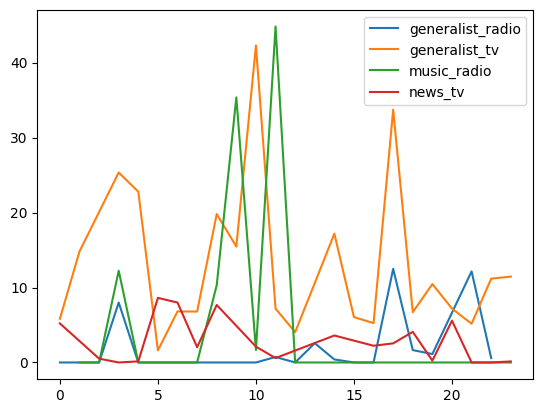

In [32]:
import pylab as pl
for k, sdf in sr.groupby('channel_category'):
    print(k)
    x = sdf.index.get_level_values(1)
    y = sdf.WSTP_RMSE
    pl.plot(x, y, label=k)
pl.legend()

generalist_radio
generalist_tv
music_radio
news_tv


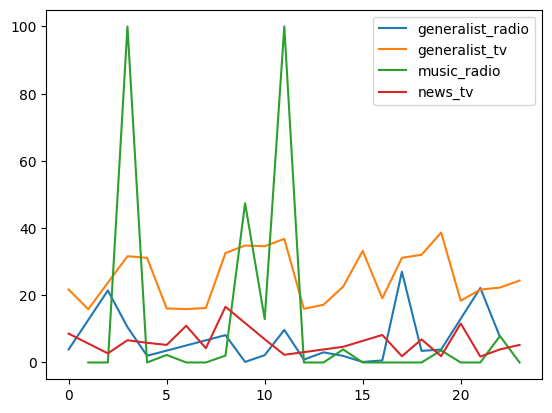

In [36]:
import pylab as pl
for k, sdf in sr.groupby('channel_category'):
    print(k)
    x = sdf.index.get_level_values(1)
    y = sdf[('IER', 'identification error rate', '%')]
    y = [min(e, 100) for e in y]
    pl.plot(x, y, label=k)
pl.legend()